# Variational Equations
For a complete introduction to variational equations, please read the paper by Rein and Tamayo (2016).

For this tutorial, we work with a two planet system. We vary the initial semi-major axis $a$ of the outer planet. Because the planets interact with each other, the final $x$-position of the inner planet at the end of the simulation will depend on the initial semi-major axis of the outer planet. We run the simulation once for a fixed $a_0$ and then use first and second order variational equations to predict the final position of the outer planet for different $a$s in a neighbourhood of $a_0$. 

To do that, let us first import REBOUND, numpy and matplotlib.

In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib;
import matplotlib.pyplot as plt

Before using variational equations, let us define a function that calculates the final position of the inner planet as a function of $a$ in the brute-force way:

In [2]:
def run_sim(a):
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a)
    
    sim.integrate(2.*np.pi*10.)
    return sim.particles[1].x

We'll use this function to create a list of *true* final positions to which we later compare our results.

In [3]:
N=400
x_exact = np.zeros((N))
a_grid = np.linspace(1.4,1.7,N)
for i,a in enumerate(a_grid):
    x_exact[i] = run_sim(a)

Running a simulation with variational equations is very easy. We start by creating a simulation and add the three particles (the star and two planets) just as before. Note that the `vary` convenience function we use below only accepts heliocentric coordinates, so we explicitly tell REBOUND that the star is the primary when adding particles to the simulation. 

We then add variational particles to the simulation. We vary one parameter ($a$) and thus need only one set of first order variational equations. The second order variational equations depend on the first order ones. Thus, when initializing them, one has to pass the set of first order variational equations using the 'first_order' parameter.

After adding a variation, one must always initialize it.  We do this below with REBOUND's `vary()` convenience function, which makes varying orbital parameters particularly easy. Alternatively, one can also initialize the variational particles directly, e.g. using  `var_da.particles[1].x = 1`. Note that variations are implemented as particles, but you they really represent derivatives of a particle's coordinates with respect to some initial parameter. For more details, see Rein and Tamayo (2016).

The function below does all that and returns the final position of the inner planet, as well as the first and second derivatives of the position with respect to $a$. 

In [4]:
def run_sim_var(a):
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=1)
    sim.add(primary=sim.particles[0],m=1e-3, a=a)
    var_da = sim.add_variation()
    var_dda = sim.add_variation(order=2, first_order=var_da)
    var_da.vary(2, "a")
    var_dda.vary(2, "a")
    
    sim.integrate(2.*np.pi*10.)
    return sim.particles[1].x, var_da.particles[1].x, var_dda.particles[1].x

We can now use the variational equations to predict the final position of the inner particle. Note that we only run one simulation, at $a_0=1.56$.

In [5]:
a_0 = 1.56
x, dxda, ddxdda = run_sim_var(a_0)
x_1st_order = np.zeros(N)
x_2nd_order = np.zeros(N)
for i,a in enumerate(a_grid):
    x_1st_order[i] = x + (a-a_0)*dxda
    x_2nd_order[i] = x + (a-a_0)*dxda + 0.5*(a-a_0)*(a-a_0)*ddxdda

In the figure below, we plot the final position as a function of the initial semi-major axis. The black line corresponds to the true final position as calculated by the brute-force approach. The dashed and dotted lines correspond to the approximations using first and second order variational equations. As one can see, the second order approximation is very accurate within a neighbourhood of $a_0$. 

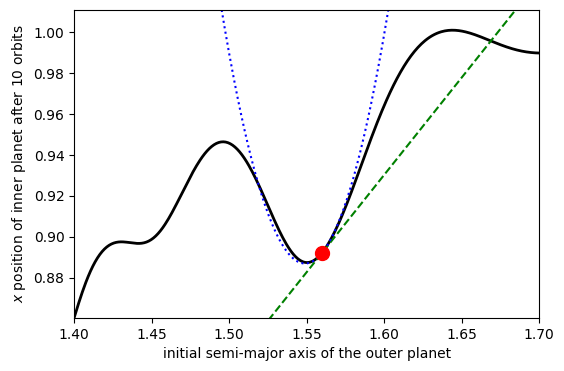

In [6]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlim(a_grid[0],a_grid[-1])
ax.set_ylim(np.min(x_exact),np.max(x_exact)*1.01)
ax.set_xlabel("initial semi-major axis of the outer planet")
ax.set_ylabel("$x$ position of inner planet after 10 orbits")
ax.plot(a_grid, x_exact, "-", color="black", lw=2)
ax.plot(a_grid, x_1st_order, "--", color="green")
ax.plot(a_grid, x_2nd_order, ":", color="blue")
ax.plot(a_0, x, "ro",ms=10);

For chaotic systems, the coordinates of variational particles grow exponentially fast. Very quickly, we might run into numerical issues because of the finite range of floating point numbers of $\approx10^{308}$. REBOUND automatically rescales first order variational variables when coordinates become larger than $10^{100}$. This is possible because first order variational equations (in contrast to second order ones) are linear. Consider the following chaotic planetary system:

In [7]:
sim = rebound.Simulation()
sim.add(m=1.) # Star
sim.add(m=0.000954, a=5.204, M=0.600, omega=0.257, e=0.048) # planet 1
sim.add(m=0.000285, a=7.2, M=0.871, omega=1.616, e=0.12)    # planet 2
sim.move_to_com()

Let us add a first order set of variational equations:

In [8]:
v = sim.add_variation()
v.particles[1].x = 1 

If we integrate this forward in time, we quickly approach the maximum range of floating point numbers:

In [9]:
sim.integrator = "whfast"
sim.dt = 5.0
times = np.linspace(0,4e5,900)
N1 = 280 # integrate first part
xs = np.zeros(len(times))
for i in range(N1):
    sim.integrate(times[i])
    xs[i] = v.particles[1].x

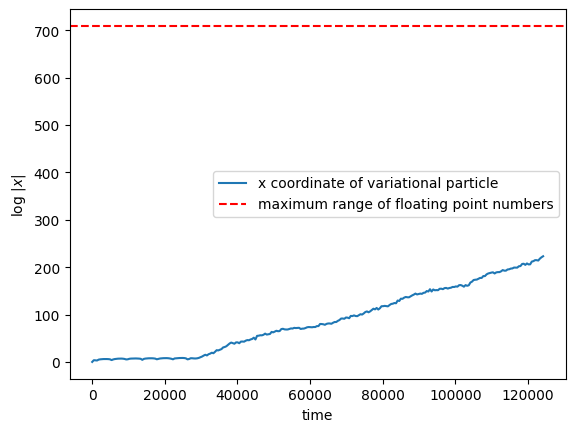

In [10]:
fig, ax = plt.subplots()
ax.set_ylabel("$\log\, |x|$")
ax.set_xlabel("time")
ax.plot(times[:N1], np.log(np.abs(xs[:N1])), label= "x coordinate of variational particle")
plt.axhline(y=709, color='r', linestyle='--', label = "maximum range of floating point numbers")
ax.legend(loc="center right");

If we integrate any further, the magnitude of at least one coordinate will exceed $10^{100} \approx e^{230}$. At this point REBOUND automatically rescales the variational particles. The natural logarithm of the rescaling factor is recorded in the `lrescale` coordinate in the variational equation structure so we can keep track of it. 

In [11]:
lrescale = np.zeros(len(times))
for i in range(N1,len(times)):
    sim.integrate(times[i])
    xs[i] = v.particles[1].x
    lrescale[i] = v.lrescale

We can use this to extend our integration beyond what would normally be possible using standard floating point numbers.

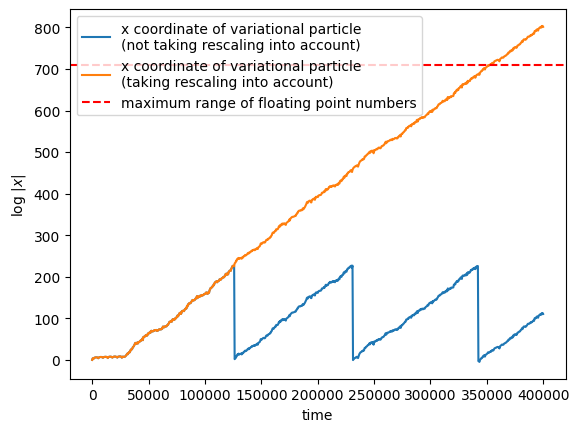

In [12]:
fig, ax = plt.subplots()
ax.set_ylabel("$\log\, |x|$")
ax.set_xlabel("time")
ax.plot(times, np.log(np.abs(xs)), label= "x coordinate of variational particle\n(not taking rescaling into account)")
ax.plot(times, np.log(np.abs(xs))+lrescale, label= "x coordinate of variational particle\n(taking rescaling into account)")
plt.axhline(y=709, color='r', linestyle='--', label = "maximum range of floating point numbers")
ax.legend(loc="upper left");